## Python examples in Sambridge et al. (2022): Ricker wavelets

This Jupyter notebook contains python code to illustrate calculations made in 

[*Geophysical Inversion and Optimal Transport* Sambridge, Jackson & Valentine, Geophysical Journal International, (2022)](https://academic.oup.com/gji/advance-article-abstract/doi/10.1093/gji/ggac151/6572363).


This notebook demonstrates calculations involving Double Ricker wavelets in Figures 1, 3 & 7.

Operation is in two modes. One where all calculations are made *on the fly* and plots produced and *read results* mode (default) which is where results of calculations are read in from a pickle file and plotted. The former can be computationally demanding because waveforms and misfits are calculated many times. 

If executing the pickle file contained in this package an option below is provided to use *on the fly* mode, and then write your own pickle files for future use in *read results* mode.


### Import libraries

In [1]:
# read standard libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from tqdm import tqdm

import ricker_util as ru     # An interface to OT calculation library as well as utility routines

---

### Optimal Transport libraries

This notebook makes use of the following python scripts:

`ricker_util.py` contains various utility plot routines used in this notebook, but also acts as an interface to two independent libraries: 

- `OTlib.py` containing the author's Optimal Transport calculation library for 1D and 2D densities fields together with derivatives.

- `FingerprintLib.py` containing routines required to calculate nearest distance fields and 2D densities for time series together with their derivatives of density field with respect to time series amplitude.


---

### Constructing Ricker wavelet synthetic waveforms

First we build some noisy double ricker wavelets used in this example.

The routine `ricker_util.rickerwavelet` is used to calculate a double ricker wavelet over the interval `(trange[0],trange[1])`.

which is defined with a reference frequency of 25Hz corresponding to a single ricker wavelet of 0.128 s. For (-2,2) this corresponds to a single ricker time window length of 2s and hence a frequency of `mtrue[2] = 1.0` corresponds to 15.625 Hz reference signal, or reference period 0.064 s.

A noise correlation length of 0.03s corresponds to 47% of the reference period.

Noise amplitude of 0.08 corresponds to 4.84 % of the maximum observed waveform height.

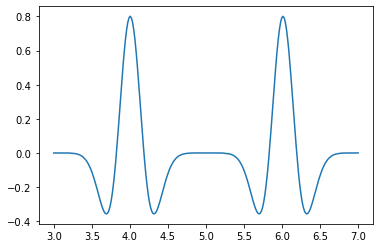

In [2]:
# plot a double Ricker wacelet for reference
tpred,wpred = ru.rickerwavelet(5.0,0.8,0.8,trange=[-2.,2.],seed=61254557) # set up test waveform
plt.plot(tpred,wpred)

### Ricker wavelets as a function of three parameters

In Sambridge et al. (2022) we set up an otimization problem fitting double Ricker wavelets using the Wasserstein misfit between their 2D fingerprints.

Parameters for optimization are: 
- timeshift between wavelets, 
- amplitude scale factor, and 
- spread parameter of Ricker wavelet.

These constitute the three parameters upon which our double Ricker wavelet depends. In Sambridge et al. (2022) we set up an optimisation problem to solve for these parameters.

The target 'observed' Ricker wavelet has added correlated, and the predicted wavelet no noise. This forms a simple three parameter optimisation problem.

In [3]:
mtrue = np.array([0.,1.6,1.]) # define true model parameters, toffset, amplitude, f-factor
trange = [-2.,2.] # range of time axis
tpred,wpred = ru.rickerwavelet(4.5,1.6,0.8,trange=trange,seed=61254557) # set up test waveform (ref)
tobs,wobs = ru.rickerwavelet(mtrue[0],mtrue[1],mtrue[2],sigma_amp=0.08,sigma_cor=0.03,trange=trange) # set up observed noisy waveform

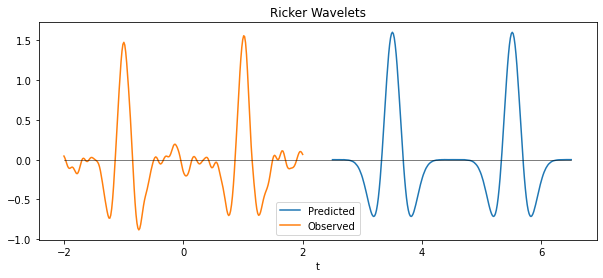

In [4]:
ru.plotrickers(tpred,wpred,tobs,wobs,filename='Figures/Obs_pred_ricker.pdf')#

In [5]:
print('Noise amplitude is :',np.round(0.08*100/np.max(wobs),3),' % of the maximum waveform height d')
print('Noise correlation length is :',0.03*100*mtrue[2]/(0.128/2),' % of a ricker period')

Noise amplitude is : 5.136  % of the maximum waveform height d
Noise correlation length is : 46.875  % of a ricker period


In [6]:
# set up range of parameters time offset, amplitude factor and frequency
tmin,tmax = -4.,4. # minimum and maximum time offset
amin,amax = 0.2,4. # minimum and maximum amplitude factor
fmin,fmax = 0.5,4. # minimum and maximum frequency factor

Set up model space search limits.

In [7]:
tlin1D = np.linspace(tmin,tmax,400)
alin1D = np.linspace(amin,amax,200)
flin1D = np.linspace(fmin,fmax,200)
tlin2D = np.linspace(tmin,tmax,200)
alin2D = np.linspace(amin,amax,200)
flin2D = np.linspace(fmin,fmax,200)

### Setup OT calculations

In [8]:
# choose grid to use
nugrid,ntgrid=40,512 # This is the discretization of the waveform window used to evaluated the density surface
lambdav = 0.03       # This is the distance scale factor used to calculate the density function (eqn. 17 of Sambridge et al. (2022))

#### Setup Time-Amplitude window 

Set up initial grid for observed and predicted waveforms.

In [9]:
grid = (trange[0], trange[1], -1.35, 2.2, nugrid,ntgrid) # specify grid for fingerprint
wfobs, wfobs_target = ru.BuildOTobjfromWaveform(tobs,wobs,grid,lambdav=lambdav)

Plot Fingerprint contours of Ricker wavelet.

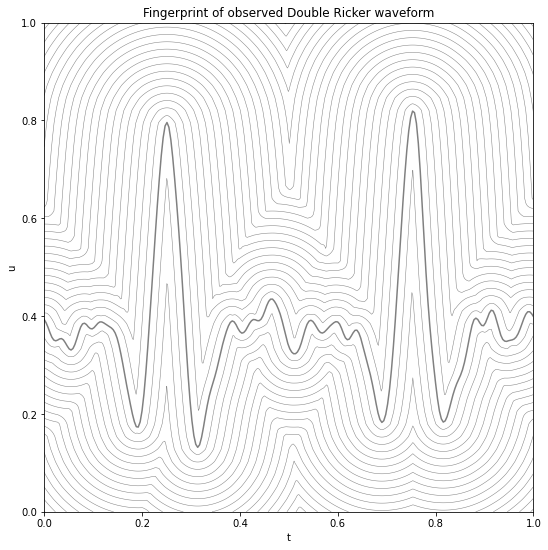

In [10]:
ru.fp.plot_LS(wfobs.dfield,wfobs,None,None,'Fingerprint of observed Double Ricker waveform','grey','grey',aspect=True,filename='Figures/Ricker_obs_fingerprint.pdf') 

This is the nearest distance field calculation shown in Figure 3 of Sambridge et al. (2022).

Initial Amplitude Time window parameter are set as
grid = (-2., 2., -1.35, 2.2, nugrid,ntgrid)
nugrid,ntgrid = 40,512

The amplitude window proved too small for all amplitude factors in the sweep so we change this to grid = (-2., 2., -1.8, 4.2, nugrid,ntgrid)


In [11]:
grid = (trange[0], trange[1], -1.80, 4.2, 2*nugrid,ntgrid) # expand grid
wfobs, wfobs_target = ru.BuildOTobjfromWaveform(tobs,wobs,grid,lambdav=lambdav) # build data object

### Calculate misfit profiles and surfaces

Here we decide to either calculate the 2D misfit surfaces and write them out to a pickle file, which is computationally slow, or read the results in from a pre-calculated pickle file (quick).


In [12]:
# read results from pickle file (fast)
readresults = True       # read in all misfit profiles (1D & 2D) from previously computed pickle file (if False 1D profile calculated internally)
calc2DWsurfaces = False    # option to calculate 2D W surfaces if readresults=False (This is expensive and so can be turned off)
writepicklefile = False    # Write out pickle file of all results, usually only if readresults=False.
pickle_filename = 'pickles/Wasserstein_L2W2_misfits_ricker.pickle' # standard pickle filename

#### Reading and writing pickle files

Here pickle files are provided for convenience to avoid lengthy run times. If reading and executing the pickle file distributed with this package is not desired, this may be avoided using the settings in the next cell to instead overwrite the pickle file with local calculations. This will, however, take some time.

To perform calculations internally and write your own pickle execute the next cell.

In [13]:
# Perform calculations internally (slow)
if(False):
    readresults = False       # read in all misfit profiles (1D & 2D) from previously computed pickle file (if False 1D profile calculated internally)
    calc2DWsurfaces = True    # option to calculate 2D W surfaces if readresults=False (This is expensive and so can be turned off)
    writepicklefile = True    # Write out pickle file of all results, usually only if readresults=False.
    pickle_filename = 'pickles/Wasserstein_L2W2_misfits_ricker.pickle' # standard pickle filename

In [14]:
# read results from previous run
if(readresults): 
    p = ru.readpickle(pickle_filename)

### Perform scan over time axis for Wasserstein distance.

Here we perform calculations comparing Wasserstein and $L_2^2$ misfit as a function of time offset.

In [15]:
# Calculate L2 and Wasserstein misfit along toffset axis
if(readresults):
    W1misfit_t = p['W1misfit_t']
    W2misfit_t = p['W2misfit_t']
    l2_t = p['l2_t']
else:
    W1misfit_t = np.zeros(len(tlin1D))
    W2misfit_t = np.zeros(len(tlin1D))
    l2misfitF = np.zeros(len(tlin1D))
    l2_t = np.zeros(len(tlin1D))
    for i in tqdm(range(len(tlin1D))):
        to = tlin1D[i]
        tpred,wpred = ru.rickerwavelet(to,mtrue[1],mtrue[2],trange=trange) # set up predicted waveform for these model parameters
        wfs,wfsource = ru.BuildOTobjfromWaveform(tpred,wpred,grid,lambdav=lambdav)
    
        w1 = ru.CalcWasserWaveform(wfsource,wfobs_target,wfs,distfunc='W1')
        w2 = ru.CalcWasserWaveform(wfsource,wfobs_target,wfs,distfunc='W2')
        
        W1misfit_t[i] = w1
        W2misfit_t[i] = w2
        # Calculate L2norm of PDF difference
        r = (wfsource.pdf-wfobs_target.pdf).flatten()
        l2misfitF[i] = np.dot(r,r)               # Least squares of 2D PDFs
        l2_t[i] = ru.LSmisfit(tobs,wobs,tpred,wpred)  # Least squares of 1D Waveforms

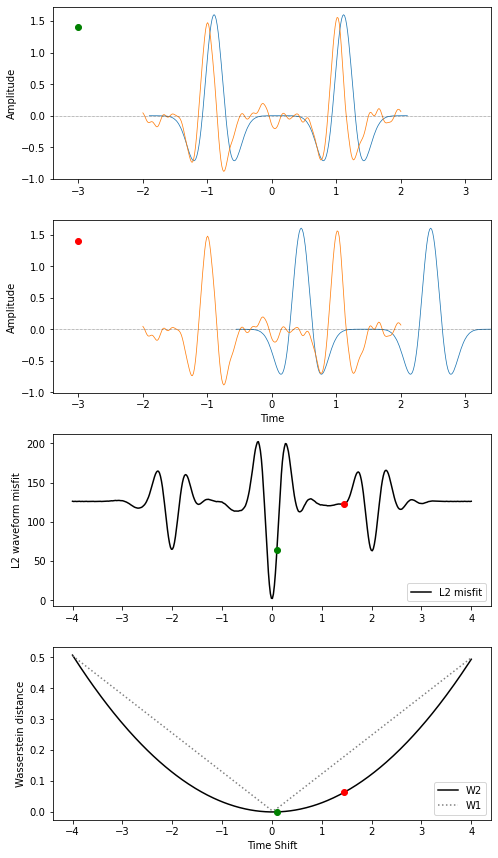

In [16]:
# Compare misfits as a function of time offset. 
if(True):
    # plot Wasserstein as a function of offset. 
    # Note here that the reference predicted waveform, tpred, is offset by 4.5s.

    ny,lx,ly = 3,7,12

    fig = plt.figure(figsize=(lx,ly))

    plt.subplot(4, 1, 1)
    tshift0,tshift1 = 0.1,1.45
    ru.plotrickers_special(tpred-4.5+tshift0,wpred,tobs,wobs,tlim=(-3.4,3.4),offset='0.1s') # offset from tobs is 4.0-3.9=0.1s
    plt.plot(-3,1.4,'go')
   #plt.legend(loc=0)
    plt.subplot(4, 1, 2)
    ru.plotrickers_special(tpred-4.5+tshift1,wpred,tobs,wobs,tlim=(-3.4,3.4),xlab=True,offset='1.5s') # offset from tobs is 4.0-2.5=1.5s
    #plt.legend(loc=0)
    plt.plot(-3,1.4,'ro')
    
    plt.subplot(4, 1, 3)
    #plt.title('Waveform misfits vs time shift')
    plt.ylabel('L2 waveform misfit')
    plt.plot(tlin1D,l2_t,'k-',label='L2 misfit')
    f = interpolate.interp1d(tlin1D, l2_t)
    plt.plot(tshift0,f(tshift0),'go')
    f2 = interpolate.interp1d(tlin1D, l2_t)
    plt.plot(tshift1,f(tshift1),'ro')
    plt.legend(loc=4)

    plt.subplot(4, 1, 4)
    #plt.ylabel('Wasserstein misfit')
    plt.xlabel('Time Shift')
    plt.ylabel('Wasserstein distance')
    plt.plot(tlin1D,W2misfit_t,'k-',label='W2')
    plt.plot(tlin1D,W1misfit_t,':',color='grey',label='W1')
    f = interpolate.interp1d(tlin1D, W2misfit_t)
    plt.plot(tshift0,f(tshift0),'go')
    f2 = interpolate.interp1d(tlin1D, W2misfit_t)
    plt.plot(tshift1,f(tshift1),'ro')
    plt.legend(loc=4)

    plt.tight_layout(pad=1.0)
        
    plt.savefig('Figures/Ricker_fitting.pdf')
    
plt.show()

This is Figure 1 of the paper. 

## 3D plots of Least squares and Wasserstein misfit

In [17]:
# Calculate L2 and Wasserstein misfit along toffset vs axis
if(readresults): # use misfit surface data obstianed from pickle file rather than re-calculate (expensive)
    W1misfit_2D_at = p['W1misfit_2D_at']
    W2misfit_2D_at = p['W2misfit_2D_at']
    l2_2D_at = p['l2_2D_at']
    alin2D = p['alin2D']
    tlin2D = p['tlin2D']
else:
    x,y = tlin2D,alin2D
    W1misfit_2D_at = np.zeros((len(y),len(x)))
    W2misfit_2D_at = np.zeros((len(y),len(x)))
    l2_2D_at = np.zeros((len(y),len(x)))
    for i in tqdm(range(len(y))):
        for j in range(len(x)):
            to = x[i]
            a = y[j]
            tpred,wpred = ru.rickerwavelet(to,a,mtrue[2],trange=trange) # set up predicted waveform for these model parameters
            if(calc2DWsurfaces):
                wfs,wfsource = ru.BuildOTobjfromWaveform(tpred,wpred,grid,lambdav=lambdav)
    
                w1 = ru.CalcWasserWaveform(wfsource,wfobs_target,wfs,distfunc='W1')
                w2 = ru.CalcWasserWaveform(wfsource,wfobs_target,wfs,distfunc='W2')
        
                W1misfit_2D_at[i,j] = w1
                W2misfit_2D_at[i,j] = w2
            l2_2D_at[i,j] = ru.LSmisfit(tobs,wobs,tpred,wpred)  # Least squares of 1D Waveforms

Write out pickle file so that next time we don't have to recalculate these surfaces.

In [18]:
# set up list of arrays to write to pickle file (Optional)
listOfStr = ['nugrid','ntgrid','lambdav','grid','mtrue','tlin1D','alin1D','flin1D','wfobs_target','wfobs','l2_t','W1misfit_t',
            'W2misfit_t','tlin2D','alin2D','flin2D','l2_2D_at','W1misfit_2D_at','W2misfit_2D_at']
listOfdata = [nugrid,ntgrid,lambdav,grid, mtrue,tlin1D,alin1D,flin1D,wfobs_target,wfobs,l2_t,
                W1misfit_t,W2misfit_t,tlin2D,alin2D,flin2D,l2_2D_at, W1misfit_2D_at, W2misfit_2D_at]
if(writepicklefile): # Optionally write out misfit profile and surface data to pickle file 
    ru.writepickle('W2Dmisfit_at.pickle',listOfStr,listOfdata) 

Plot $L_2^2$ waveform misfit surface as a function of Amplitude and time-shift parameters. 

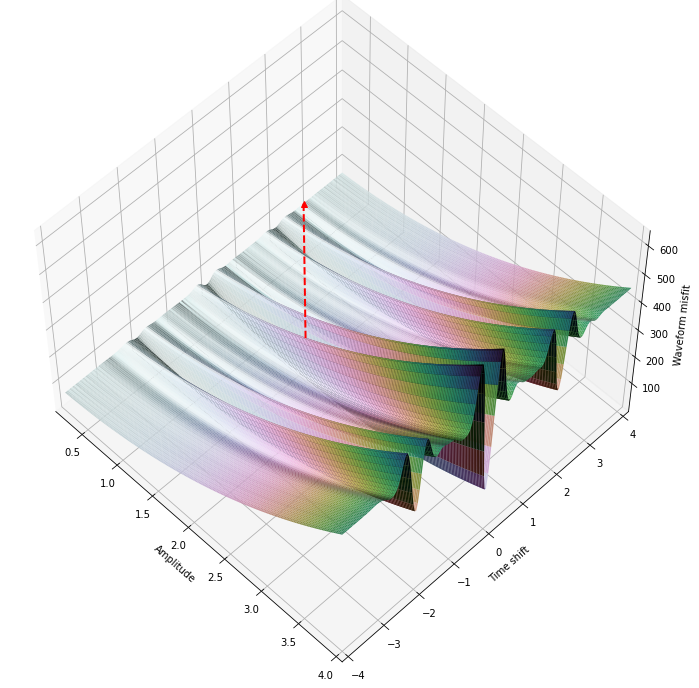

In [19]:
ru.plotsurface(l2_2D_at,alin2D,tlin2D,mtrue[1],mtrue[0],
             xlab='Amplitude',ylab='Time shift',lw=2.0,lstyle='r--',l=0.23,dpi=100,
             filename='Figures/L2surface.png')

This is the top panel of Figure 7 in Sambridge et al. (2022).

Plot $W_1$ waveform misfit surface as a function of Amplitude and time-shift parameters. 

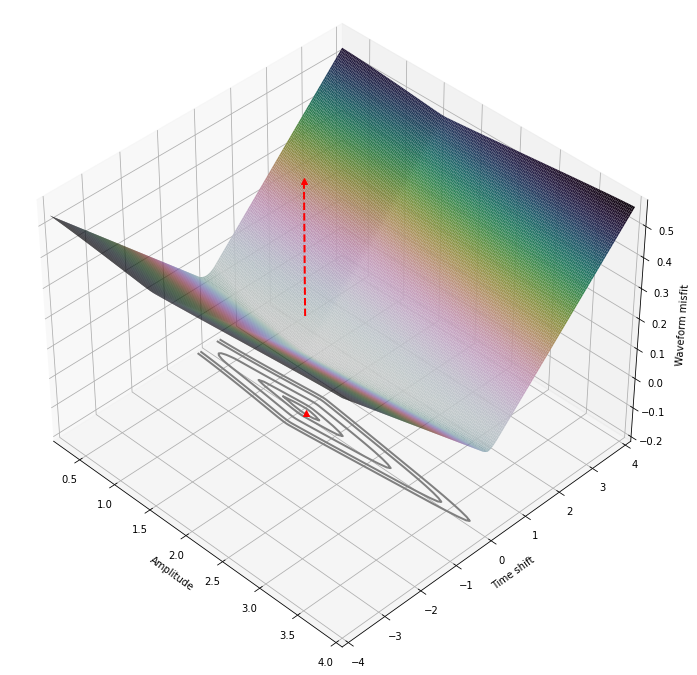

In [20]:
ru.plotsurface(W1misfit_2D_at,alin2D,tlin2D,mtrue[1],mtrue[0],
             xlab='Amplitude',ylab='Time shift',lw=2.0,l=0.23,alt=40.,base=True,
             offset=-0.2,lstyle='r--',levels=[0.01,0.02,0.04,0.06,0.07],dpi=100,
             filename='Figures/W1surface.png')

This is the middle panel of Figure 7 in Sambridge et al. (2022).

Plot $W_2^2$ waveform misfit surface as a function of Amplitude and time-shift parameters. 

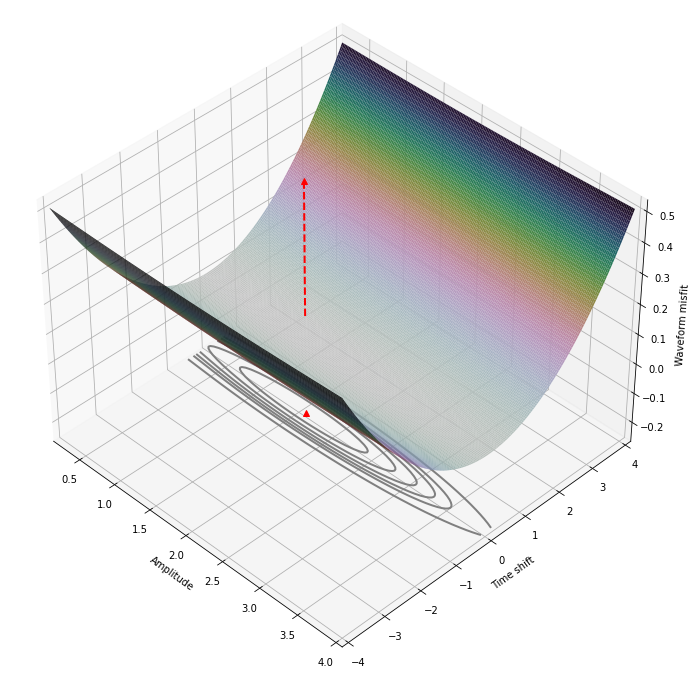

In [21]:
ru.plotsurface(W2misfit_2D_at,alin2D,tlin2D,mtrue[1],mtrue[0],
             xlab='Amplitude',ylab='Time shift',lw=2.0,l=0.15,alt=40.,base=True,
             offset=-0.25,lstyle='r--',levels=[0.002,0.004,0.006,0.008,0.01,0.015],dpi=100,
             filename='Figures/W2surface.png')

This is the lower panel of Figure 7 in Sambridge et al. (2022).

In [22]:
wfs

NameError: name 'wfs' is not defined